In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(12,6))
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Kaggle/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


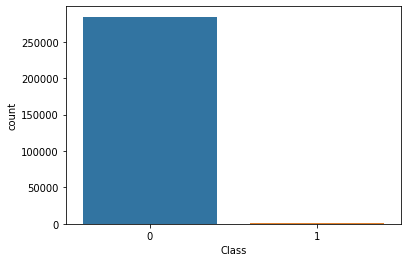

In [ ]:
sns.countplot(df['Class'])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Another columns have already scaled
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Time','Amount'],axis=1)

# Undersampling & Logistic Regression

In [ ]:
num_fraud = len(df[df.Class == 1])
fraud_indices = np.array(df[df.Class == 1].index)
normal_indices = df[df.Class == 0].index

# Undersample into same number as fraud classes
random_normal_indices = np.random.choice(normal_indices, num_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# Select undersampled data
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = df.iloc[under_sample_indices,:]
X_undersample = under_sample_data.drop('Class', axis=1)
y_undersample = under_sample_data['Class']

under_sample_data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# Whole dataset
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size=0.3
                                                                                                   ,random_state=21)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()

# Search the best parameter
c = [100, 10, 1.0, 0.1, 0.01]
param_grid = dict(C=c)
grid_search = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_undersample, y_train_undersample)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.980739 using {'C': 0.01}
0.972775 (0.013932) with: {'C': 100}
0.973398 (0.012547) with: {'C': 10}
0.975898 (0.010508) with: {'C': 1.0}
0.979389 (0.010802) with: {'C': 0.1}
0.980739 (0.009677) with: {'C': 0.01}


Text(0.5, 1.0, 'Undersampled Dataset')

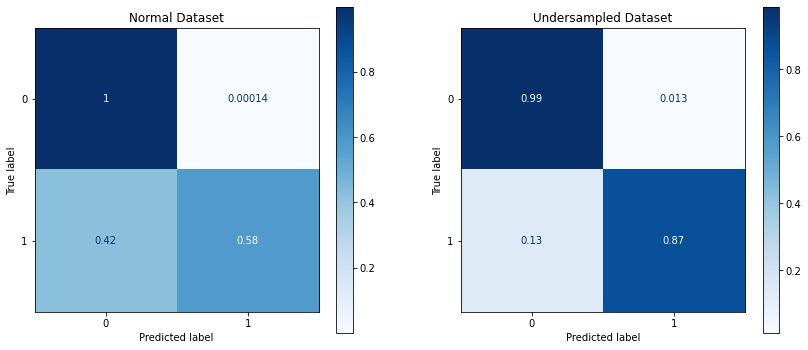

In [ ]:
lr = LogisticRegression(C=0.01)
lr.fit(X_train, y_train)
lr_under = LogisticRegression(C=0.01)
lr_under.fit(X_train_undersample, y_train_undersample)

fig, ax = plt.subplots(1,2,figsize=(14,6))

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', normalize='true', ax=ax[0])
ax[0].set_title("Normal Dataset")
plot_confusion_matrix(lr_under, X_test_undersample, y_test_undersample, cmap='Blues', normalize='true', ax=ax[1])
ax[1].set_title("Undersampled Dataset")

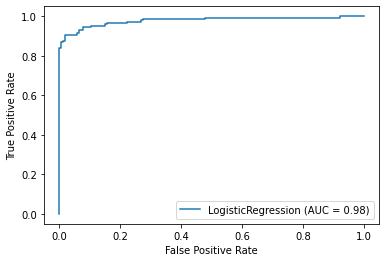

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(lr_under, X_test_undersample, y_test_undersample)

# Autoencoder

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Kaggle/creditcard.csv")
df["Time"] = df["Time"].apply(lambda x: x / 3600 % 24)

In [ ]:
# Consider only 1000 rows
non_fraud = df[df['Class'] == 0].sample(1000)
fraud = df[df['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

X = df.drop('Class', axis=1)
y = df["Class"]

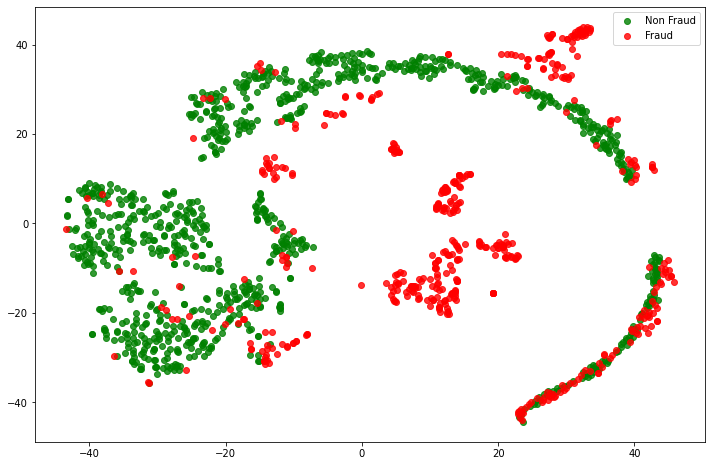

In [ ]:
from sklearn.manifold import TSNE

# Plotting T-SNE dimensionality reduction
def tsne_plot(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    x = tsne.fit_transform(x)

    plt.figure(figsize=(12,8))
    plt.scatter(x[np.where(y == 0), 0], x[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(x[np.where(y == 1), 0], x[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.show()
    
tsne_plot(X, y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X.values)
X_norm, X_fraud = X_scaled[y == 0], X_scaled[y == 1]

In [ ]:
from keras.layers import Input, Dense
from keras import regularizers

# Input layer 
input_layer = Input(shape=(X.shape[1],))

# Encoding layer
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# Decoding Layer
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# Output Layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [ ]:
from keras.models import Model

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [ ]:
autoencoder.fit(X_norm[0:2000], X_norm[0:2000], 
                batch_size=256, epochs=500, 
                shuffle=True, validation_split=0.20);

Epoch 1/500
4/4 [==============================] - 0s 28ms/step - loss: 0.2858 - val_loss: 0.2834
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 0.2854 - val_loss: 0.2830
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2851 - val_loss: 0.2827
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2848 - val_loss: 0.2823
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2844 - val_loss: 0.2820
Epoch 6/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2841 - val_loss: 0.2816
Epoch 7/500
4/4 [==============================] - 0s 13ms/step - loss: 0.2837 - val_loss: 0.2813
Epoch 8/500
4/4 [==============================] - 0s 52ms/step - loss: 0.2833 - val_loss: 0.2809
Epoch 9/500
4/4 [==============================] - 0s 15ms/step - loss: 0.2830 - val_loss: 0.2806
Epoch 10/500
4/4 [==============================] - 0s 14ms/step - loss: 0.2826 - val_loss: 0.2802
Epoch 11/500
4/4 [=

In [ ]:
from keras.models import Sequential

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [ ]:
norm_hid_rep = hidden_representation.predict(X_norm[:3000])
fraud_hid_rep = hidden_representation.predict(X_fraud)

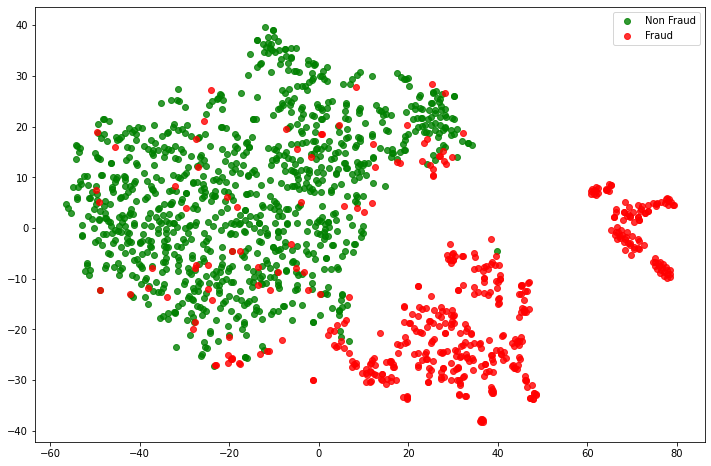

In [ ]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y)

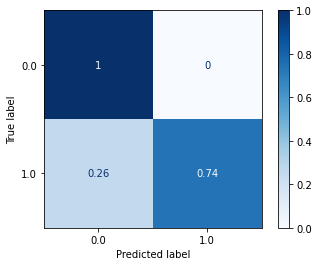

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

lr = LogisticRegression(solver="lbfgs")
lr.fit(train_x, train_y)

plot_confusion_matrix(lr, val_x, val_y, cmap='Blues', normalize='true')

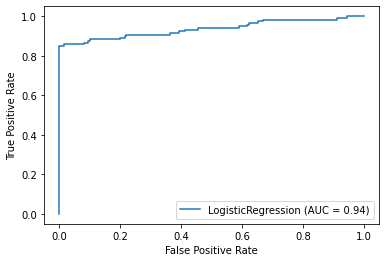

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(lr, val_x, val_y)